In [1]:
import pandas as pd
import requests
import re
import time
from bs4 import BeautifulSoup

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Functions

In [3]:
def fetch(url):
    """
    Use BeautifulSoup to get the text of a web page.
    """
    r = requests.get(url)
    comm = re.compile("<!--|-->")
    soup = BeautifulSoup(comm.sub("", r.text), "html.parser")
    return soup

Steps:  
- Go to draft year page at BBR and identify CBB players 
- Go to the bio pages at BBR of all the CBB draftees and find their bio pages at Sports-Reference 
- Scotch tape the draft class to college data

In [4]:
def get_draftee_spr_page(player_bbr_url):
    """
    Input: a draftee's url at BBR
    Output: a draftee's url at Sports-Reference
    """
    spr_url = 'https://www.sports-reference.com'
    bbr_bio_soup = fetch(player_bbr_url)
    div_soup = bbr_bio_soup.find_all('div', {'id': 'inner_nav'})[0]
    for link in div_soup.find_all('a'):
        if spr_url in link['href']:
            return link['href'].replace(spr_url, '')

In [5]:
def get_draft_list(year):
    """
    Input: draft year
    Output: a dataframe of a list of draftees
    """
    
    print(f'NBA Draft {year} Scraping...')
    
    bbr_url = 'https://www.basketball-reference.com'
    draft_yr_url = f'{bbr_url}/draft/NBA_{year}.html'
    draft_yr_soup = fetch(draft_yr_url)
    draft_table = draft_yr_soup.find_all('table', {'id': 'stats'})[0]
    
    draftee_list = []
    for row in draft_table.find_all('tr'):
        if row.find_all('td', {'data-stat': 'pick_overall'}):
            pick = row.find_all('th')[0].text
            player = row.find_all('td', {'data-stat': 'player'})[0].text
            college_name = row.find_all('td', {'data-stat': 'college_name'})[0].text
            player_bbr_url = f"{bbr_url}{row.find_all('td', {'data-stat': 'player'})[0].a['href']}"
            if college_name != '':
                player_spr_url = get_draftee_spr_page(player_bbr_url)
            else:
                player_spr_url = None
                
            draftee_list.append([pick, player, college_name, player_spr_url])
    
    cols = ['pick', 'player', 'school_name', 'spr_url']
    draftee_df = pd.DataFrame(draftee_list, columns=cols)
    
    print(f'NBA Draft {year} Completed.')
    print()
    
    return draftee_df

In [6]:
def get_draft_info(year):
    """
    Input: draft year
    Output: a dataframe of draftees' info
    """
    
    draftee_df = get_draft_list(year)
    cbb_df = pd.read_csv(f'cbb_year_bpm/{year}.csv')
    return draftee_df.merge(cbb_df.drop(['player', 'school_name', 'season'], axis=1), 
                            on=['spr_url'], how='left')

## Scrape

In [8]:
for year in range(2011, 2022):
    get_draft_info(year).to_csv(f'nba_draft_year_bpm/{year}.csv', index=False)
    time.sleep(10)

NBA Draft 2011 Scraping...
NBA Draft 2011 Completed.

NBA Draft 2012 Scraping...
NBA Draft 2012 Completed.

NBA Draft 2013 Scraping...
NBA Draft 2013 Completed.

NBA Draft 2014 Scraping...
NBA Draft 2014 Completed.

NBA Draft 2015 Scraping...
NBA Draft 2015 Completed.

NBA Draft 2016 Scraping...
NBA Draft 2016 Completed.

NBA Draft 2017 Scraping...
NBA Draft 2017 Completed.

NBA Draft 2018 Scraping...
NBA Draft 2018 Completed.

NBA Draft 2019 Scraping...
NBA Draft 2019 Completed.

NBA Draft 2020 Scraping...
NBA Draft 2020 Completed.

NBA Draft 2021 Scraping...
NBA Draft 2021 Completed.



In [7]:
year = 2022
get_draft_info(year).to_csv(f'nba_draft_year_bpm/{year}.csv', index=False)

NBA Draft 2022 Scraping...
NBA Draft 2022 Completed.



## EDA

In [8]:
draftee_dict = {}
for year in range(2011, 2023):
    draftee_df = pd.read_csv(f'nba_draft_year_bpm/{year}.csv') 
    draftee_df['year'] = year
    print(f'NBA Draft {year}')
    max_bpm_player_row = draftee_df[draftee_df['bpm'] == draftee_df['bpm'].max()]
    min_bpm_player_row = draftee_df[draftee_df['bpm'] == draftee_df['bpm'].min()]
    print(f"Player with Highest BPM: {max_bpm_player_row['player'].values[0]}({draftee_df['bpm'].max()})")
    print(f"Player with Lowest BPM: {min_bpm_player_row['player'].values[0]}({draftee_df['bpm'].min()})")
    print()
    draftee_dict[year] = draftee_df

NBA Draft 2011
Player with Highest BPM: Kyrie Irving(14.8)
Player with Lowest BPM: Josh Selby(2.4)

NBA Draft 2012
Player with Highest BPM: Anthony Davis(17.2)
Player with Lowest BPM: Kevin Murphy(0.6)

NBA Draft 2013
Player with Highest BPM: Victor Oladipo(15.1)
Player with Lowest BPM: Archie Goodwin(2.1)

NBA Draft 2014
Player with Highest BPM: K.J. McDaniels(12.9)
Player with Lowest BPM: Johnny O'Bryant(1.3)

NBA Draft 2015
Player with Highest BPM: Frank Kaminsky(16.2)
Player with Lowest BPM: Marcus Thornton(1.3)

NBA Draft 2016
Player with Highest BPM: Denzel Valentine(15.6)
Player with Lowest BPM: Stephen Zimmerman(1.4)

NBA Draft 2017
Player with Highest BPM: Sindarius Thornwell(17.1)
Player with Lowest BPM: Ike Anigbogu(0.9)

NBA Draft 2018
Player with Highest BPM: Mikal Bridges(12.9)
Player with Lowest BPM: Kostas Antetokounmpo(-2.1)

NBA Draft 2019
Player with Highest BPM: Zion Williamson(20.1)
Player with Lowest BPM: Justin James(2.7)

NBA Draft 2020
Player with Highest BPM: 

Show records of draftees with a subzero BPM in their final CBB seasons

In [9]:
draft_records = pd.concat([draftee_dict[year] for year in range(2011, 2023)])
draft_records[draft_records['bpm'] < 0]

,pick,player,school_name,spr_url,class,pos,g,mp,bpm,conference,year
59,60,Kostas Antetokounmpo,Dayton,/cbb/players/kostas-antetokounmpo-1.html,FR,F,29.0,438.0,-2.1,atlantic-10,2018
27,28,Patrick Baldwin Jr.,UW-Milwaukee,/cbb/players/patrick-baldwinjr-1.html,FR,G,11.0,314.0,-1.8,horizon,2022


Show records of draftees with an under-2 BPM in their final CBB seasons

In [10]:
draft_records = pd.concat([draftee_dict[year] for year in range(2011, 2023)])
draft_records[draft_records['bpm'] < 2].sort_values('bpm')

,pick,player,school_name,spr_url,class,pos,g,mp,bpm,conference,year
59,60,Kostas Antetokounmpo,Dayton,/cbb/players/kostas-antetokounmpo-1.html,FR,F,29.0,438.0,-2.1,atlantic-10,2018
27,28,Patrick Baldwin Jr.,UW-Milwaukee,/cbb/players/patrick-baldwinjr-1.html,FR,G,11.0,314.0,-1.8,horizon,2022
9,10,Ziaire Williams,Stanford,/cbb/players/ziaire-williams-1.html,FR,F,20.0,558.0,0.3,pac-12,2021
46,47,Kevin Murphy,Tennessee Technological University,/cbb/players/kevin-murphy-1.html,SR,G,33.0,1139.0,0.6,ovc,2012
46,47,Ike Anigbogu,UCLA,/cbb/players/ike-anigbogu-1.html,FR,F,29.0,377.0,0.9,pac-12,2017
29,30,Peyton Watson,UCLA,/cbb/players/peyton-watson-1.html,FR,G,32.0,405.0,1.1,pac-12,2022
35,36,Johnny O'Bryant,LSU,/cbb/players/johnny-obryant-1.html,JR,F,34.0,1020.0,1.3,sec,2014
44,45,Marcus Thornton,William & Mary,/cbb/players/marcus-thornton-3.html,SR,G,33.0,1210.0,1.3,colonial,2015
24,25,Blake Wesley,Notre Dame,/cbb/players/blake-wesley-1.html,FR,G,35.0,1027.0,1.3,acc,2022
39,40,Bryce McGowens,Nebraska,/cbb/players/bryce-mcgowens-1.html,FR,G,31.0,1032.0,1.3,big-ten,2022


Show records of draftees who played less than 10 games in their final CBB seasons

In [11]:
draft_records[draft_records['g'] <= 10].sort_values('bpm')

,pick,player,school_name,spr_url,class,pos,g,mp,bpm,conference,year
4,5,Darius Garland,Vanderbilt,/cbb/players/darius-garland-1.html,FR,G,5.0,139.0,4.9,sec,2019
20,21,Mitch McGary,Michigan,/cbb/players/mitch-mcgary-1.html,SO,F,8.0,198.0,8.6,big-ten,2014
13,14,Michael Porter Jr.,Missouri,/cbb/players/michael-porterjr-1.html,FR,F,3.0,53.0,8.6,sec,2018
43,44,Bol Bol,Oregon,/cbb/players/bol-bol-1.html,FR,C,9.0,268.0,13.0,pac-12,2019
1,2,James Wiseman,Memphis,/cbb/players/james-wiseman-1.html,FR,C,3.0,69.0,18.0,aac,2020


Get the weight of draftees with an above-5 BPM in their final CBB seasons

In [12]:
cbb_draft_records = draft_records[~draft_records['class'].isna()]
above_5_records = cbb_draft_records[cbb_draft_records["bpm"] >= 5]
print(above_5_records.shape[0])
print(f'{above_5_records.shape[0] / len(cbb_draft_records) :.1%}')

497
87.3%


Conference Distribution

In [13]:
print('2011-2022')
print('Number of Draftees:', draft_records.shape[0])
print('Number of Draftees who spent their final year in college:', cbb_draft_records.shape[0])
power_five = ['acc', 'big-ten', 'big-12', 'pac-12', 'sec']
power_five_records = cbb_draft_records[cbb_draft_records['conference'].isin(power_five)]
power_five_pct = power_five_records.shape[0] / cbb_draft_records.shape[0]
print(f'Number of Draftees from Power Five Conferences: {power_five_records.shape[0]} ({power_five_pct:.1%})')
mid_majors = ['big-east', 'aac', 'atlantic-10', 'mwc', 'wcc']
mid_majors_records = cbb_draft_records[cbb_draft_records['conference'].isin(mid_majors)]
mid_majors_pct = mid_majors_records.shape[0] / cbb_draft_records.shape[0]
print(f'Number of Draftees from top 5 Mid-Majors conferences: {mid_majors_records.shape[0]} ({mid_majors_pct:.1%})')
remaining_records = cbb_draft_records[(~cbb_draft_records['conference'].isin(power_five)) &
                                      (~cbb_draft_records['conference'].isin(mid_majors))]
remaining_pct = remaining_records.shape[0] / cbb_draft_records.shape[0]
print(f'Number of Draftees from the remaining conferences: {remaining_records.shape[0]} ({remaining_pct:.1%})')

2011-2022
Number of Draftees: 718
Number of Draftees who spent their final year in college: 569
Number of Draftees from Power Five Conferences: 420 (73.8%)
Number of Draftees from top 5 Mid-Majors conferences: 100 (17.6%)
Number of Draftees from the remaining conferences: 49 (8.6%)


In [14]:
f'{526 / 660 * remaining_pct * 60 :.1f}'

'4.1'

## Visualization

In [15]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

In [16]:
sns.set()
matplotlib.rc('font', family='Heiti TC')

In [17]:
def plot_draft_year(year, draftee_dict=draftee_dict):
    draftee_df = draftee_dict[year]
    draftee_df['mpg'] = draftee_df['mp'] / draftee_df['g']
    x = draftee_df['bpm'].values
    y = [60 - pick for pick in draftee_df['pick'].values]
    y_ticks = [f'{player} {pick}' for pick, player in enumerate(draftee_df['player'].values, 1)]
    
    class_dict = {'FR': '大一', 'SO': '大二', 'JR': '大三', 'SR': '大四'}
    for class_ in ['FR', 'SO', 'JR', 'SR']:
        temp = draftee_df[draftee_df['class'] == class_]
        x_c = temp['bpm'].values
        y_c = [60 - pick for pick in temp['pick'].values]
        plt.scatter(x_c, y_c, s=[i * 2.5 for i in temp['mpg'].values], label=class_dict[class_])
    
    # Less than or equal to 10 games
    u10_df = draftee_df[draftee_df['g'] <= 10]
    if len(u10_df) != 0:
        x_u10 = u10_df['bpm'].values
        y_u10 = [60 - pick for pick in u10_df['pick'].values]
        plt.scatter(x_u10, y_u10, s=[i * 2.5 for i in u10_df['mpg'].values], 
                    c='black', label='未打满10场', marker='x')
    
    plt.legend(loc=4)    
    plt.vlines(0, 0, 59, linestyles='--', colors='red', label='BPM=0')
    plt.vlines(5, 0, 59, linestyles='--', colors='green', label='BPM=5')
    plt.xlim(-4, 22)
    plt.ylim(-1, 60)
    plt.title(f'{year} NBA选秀新秀 选秀年赛季(NCAA一级联盟赛季)BPM')
    plt.yticks(y, y_ticks,rotation='horizontal')

### 2022

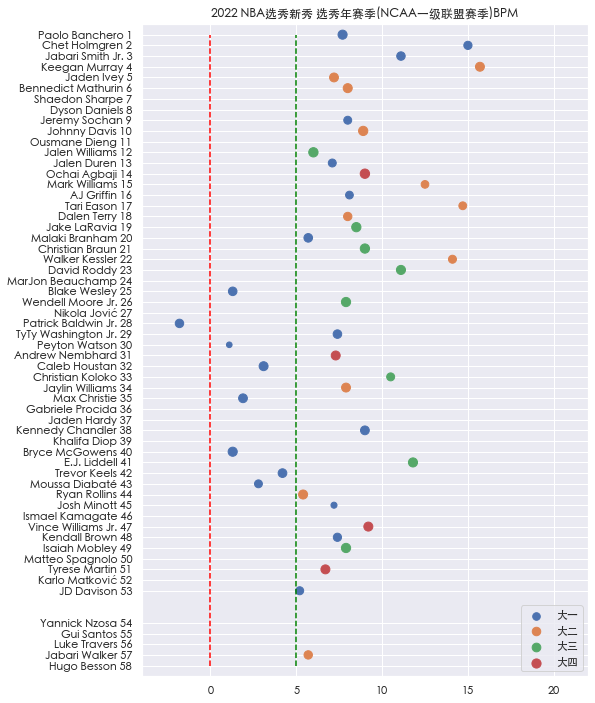

In [30]:
figsize(8, 12)
plot_draft_year(2022)

### 2021

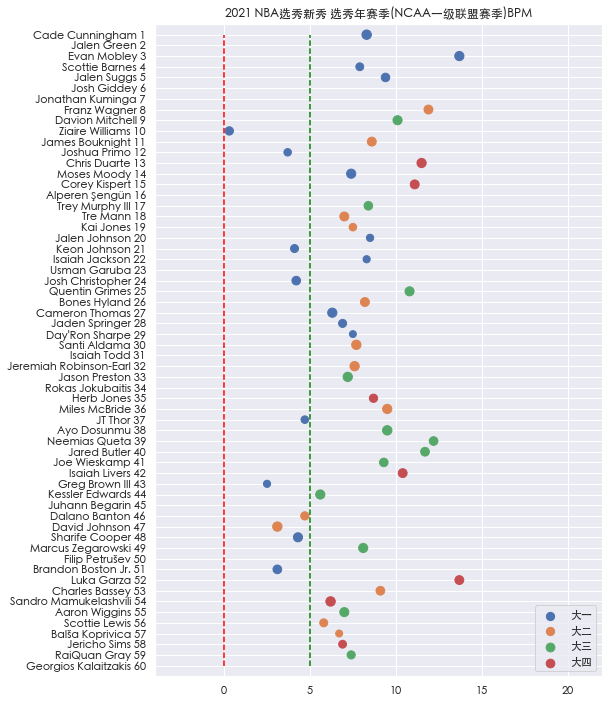

In [19]:
figsize(8, 12)
plot_draft_year(2021)

### 2020

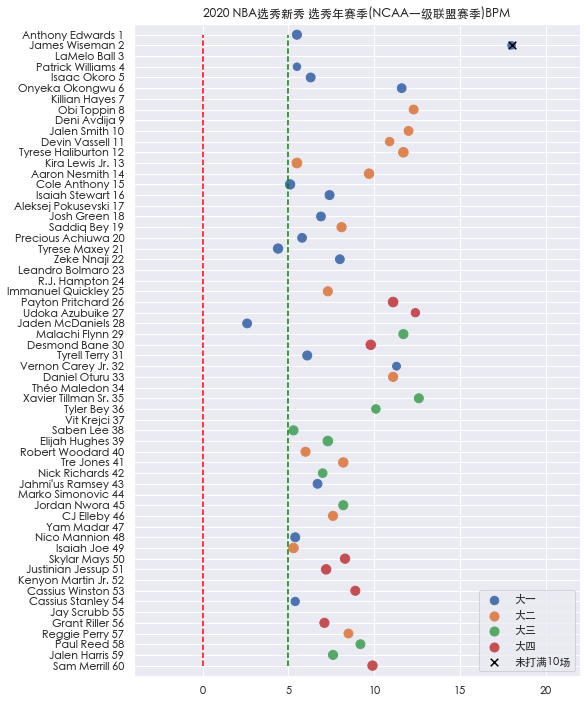

In [20]:
figsize(8, 12)
plot_draft_year(2020)

### 2019

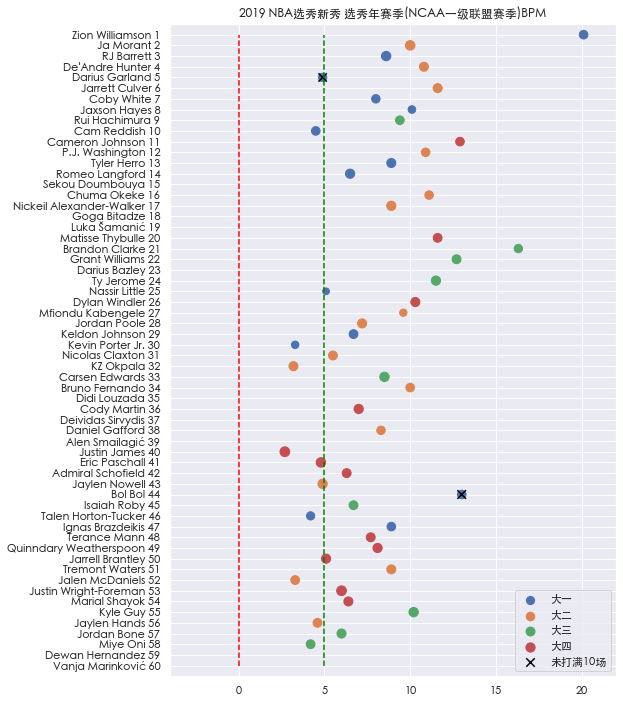

In [21]:
figsize(8, 12)
plot_draft_year(2019)

### 2018

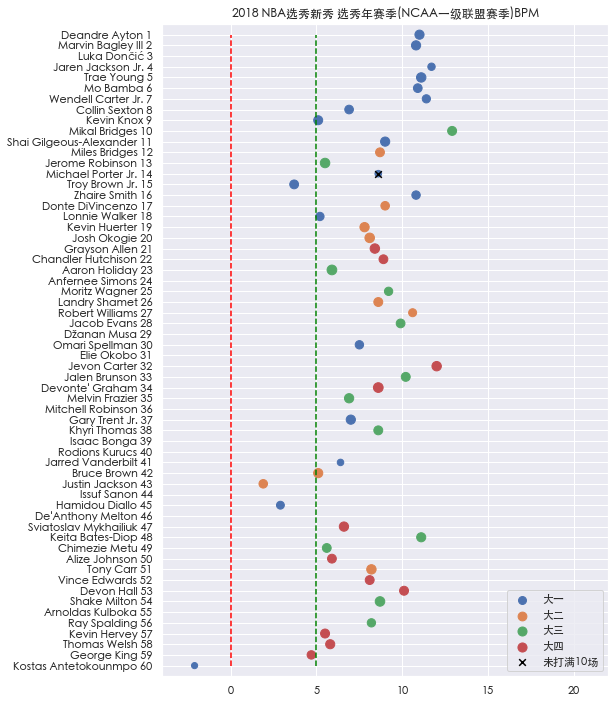

In [22]:
figsize(8, 12)
plot_draft_year(2018)

### 2017

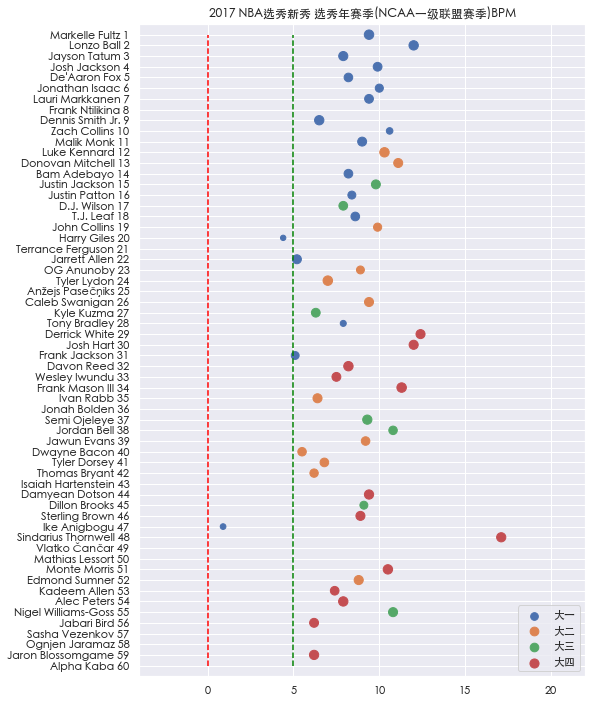

In [23]:
figsize(8, 12)
plot_draft_year(2017)

### 2016

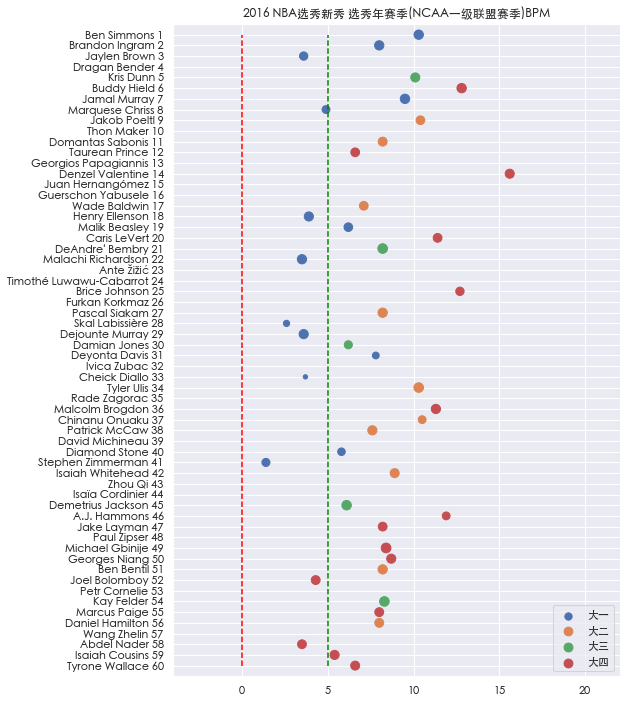

In [24]:
figsize(8, 12)
plot_draft_year(2016)

### 2015

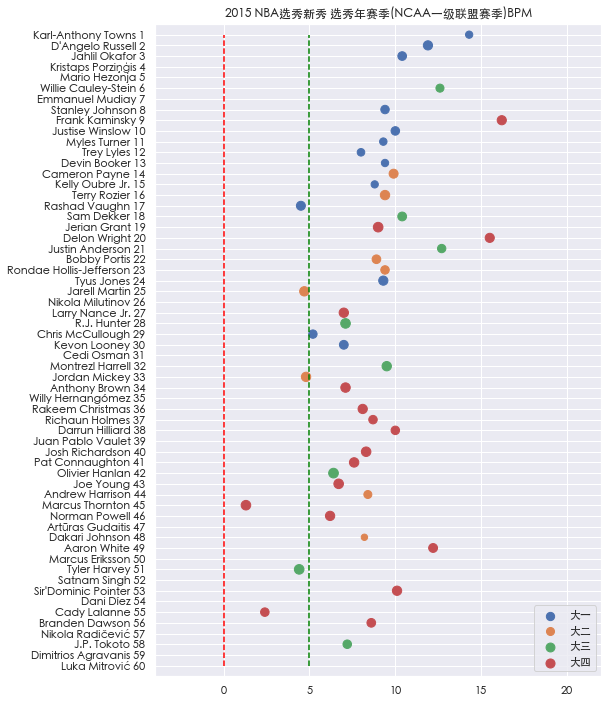

In [25]:
figsize(8, 12)
plot_draft_year(2015)

### 2014

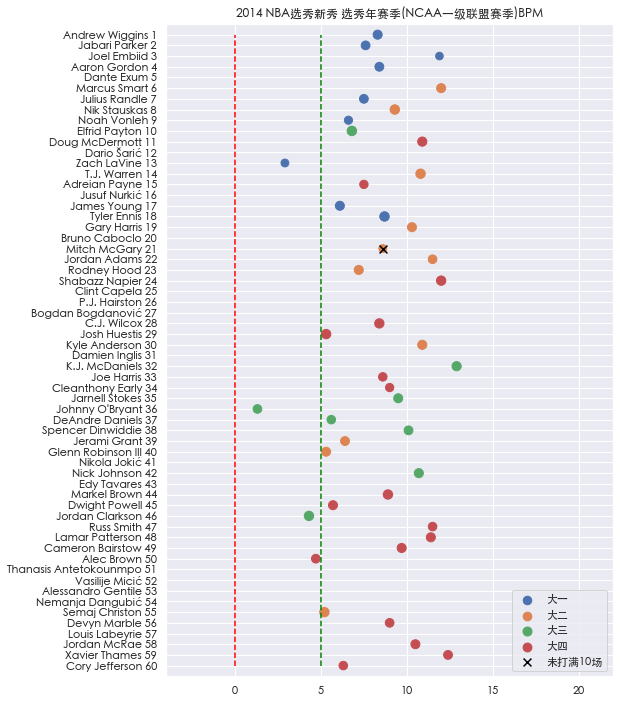

In [26]:
figsize(8, 12)
plot_draft_year(2014)

### 2013

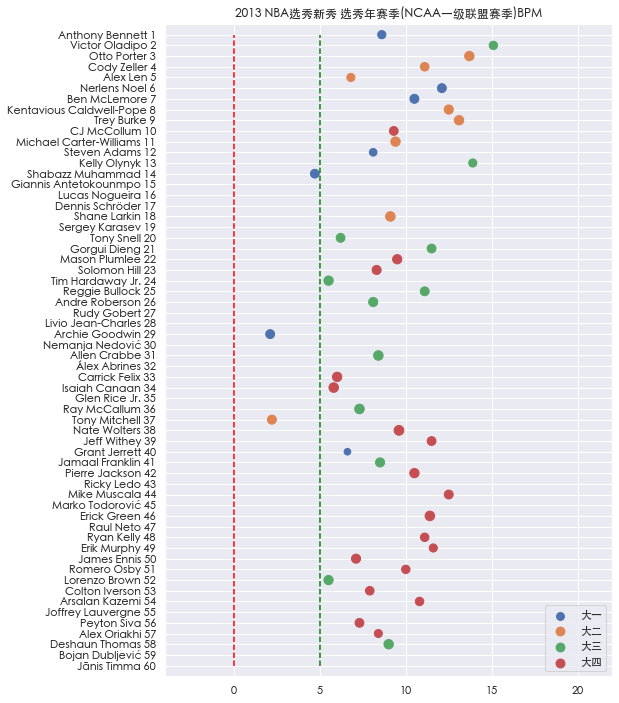

In [27]:
figsize(8, 12)
plot_draft_year(2013)

### 2012

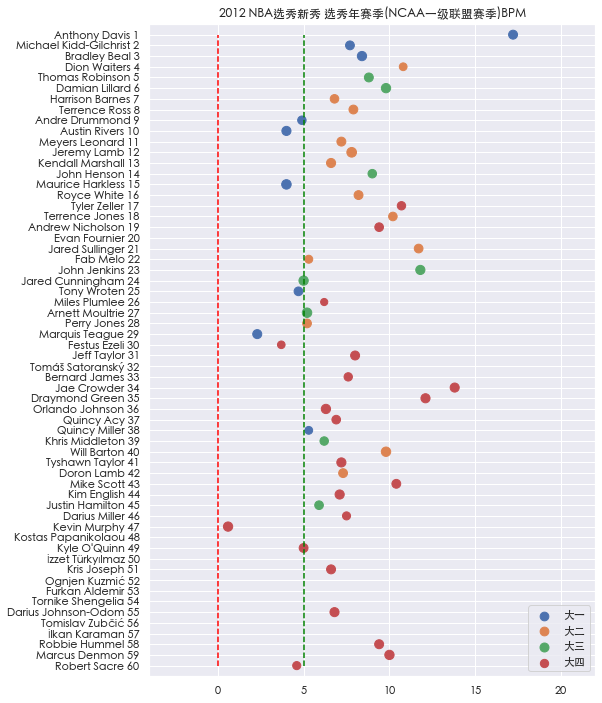

In [28]:
figsize(8, 12)
plot_draft_year(2012)

### 2011

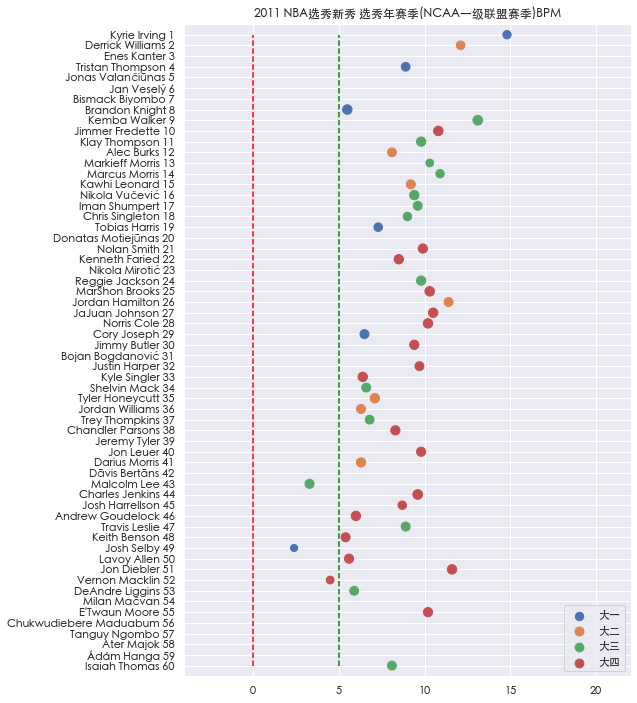

In [29]:
figsize(8, 12)
plot_draft_year(2011)